## SQL Business Analysis Project - Chinook Record Store Analysis
Soham Sen | Jan 23, 2018

### A. Import the Packages

In [32]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import seaborn as sns

%matplotlib inline

### B. Load Data and Set up Functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    qry = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(qry)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### 1. Which Artists to Sign based on Genre Popularity

In [6]:
q = '''
SELECT 
    g.name genre,
    SUM(il.quantity) tracks_sold,
    100*SUM(il.quantity)/(SELECT SUM(quantity) FROM invoice_line) AS pct
FROM genre g 
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
GROUP BY 1
ORDER BY 2 DESC
'''

tracksByGenre = run_query(q)

tracksByGenre

,genre,tracks_sold,pct
0,Rock,561,11
1,Alternative & Punk,130,2
2,Metal,124,2
3,R&B/Soul,53,1
4,Blues,36,0
5,Alternative,35,0
6,Latin,22,0
7,Pop,22,0
8,Hip Hop/Rap,20,0
9,Jazz,14,0


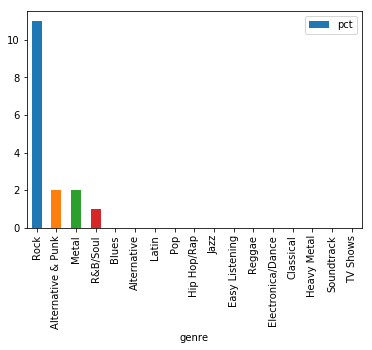

In [7]:
tracksByGenre.plot(kind='bar', x='genre', y='pct')

The analysis suggest that rock, aternative, metal and R&B are by far the highest selling genres. So the artists don't seem like a great fit for Chinook. The Punk artist Red Tone seems like the best of the lot. Then the Blues artist. Po and Hip-hop after that. 

### 2. Analyzing Employee Sales Peformance

In [8]:


q2 = '''
WITH 
    customer_sales AS 
        (
            SELECT c.*, SUM(i.total) total_sales
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY c.customer_id
            ORDER BY 2
               
        ),
    rep_sales AS
        (
            SELECT 
                support_rep_id support_rep,
                SUM(total_sales) agg_sales
            FROM customer_sales
            GROUP BY 1
            ORDER BY 2 DESC
        )

SELECT 
    rp.*, 
    e.first_name || ' ' || e.last_name fullname,
    e.title title,
    e.reports_to supervisor,
    e.country,
    e.city,
    e.hire_date
FROM rep_sales rp
INNER JOIN employee e ON e.employee_id = rp.support_rep
'''

repPerf = run_query(q2)
repPerf['hire_date'] = pd.to_datetime(repPerf.hire_date)
repPerf['experience'] = ((date.today() - repPerf.hire_date)/np.timedelta64(1, 'D')).astype(int)
repPerf


,support_rep,agg_sales,fullname,title,supervisor,country,city,hire_date,experience
0,3,1731.51,Jane Peacock,Sales Support Agent,2,Canada,Calgary,2017-04-01,298
1,4,1584.00,Margaret Park,Sales Support Agent,2,Canada,Calgary,2017-05-03,266
2,5,1393.92,Steve Johnson,Sales Support Agent,2,Canada,Calgary,2017-10-17,99


Text(0.5,1,'Sales by Rep')

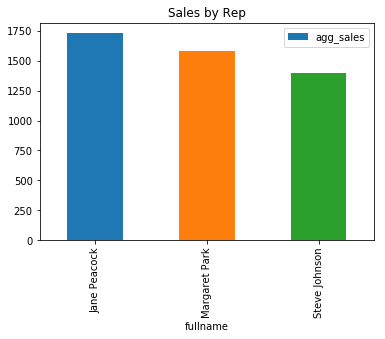

In [9]:
repPerf.plot.bar(x='fullname', y='agg_sales').set_title('Sales by Rep')

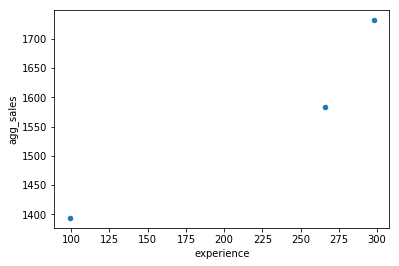

In [10]:
repPerf.plot.scatter(x='experience', y='agg_sales')

Doesn't look like there is that much difference between the three agents. Whatever variation there is is not due to supervisor or location which are same across the three. There does seem to be some correlation betwen experience and performance.

### Analyzing Sales by Country

In [64]:
q3 = '''
WITH 
    order_details AS
        (
            SELECT c.customer_id, i.invoice_id, c.country country1, i.total
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
        ),
    country_orders AS
        (
            SELECT 
                country1,
                COUNT(DISTINCT customer_id) customer_count,
                SUM(total) total_sales,
                COUNT(invoice_id) total_orders
            FROM order_details
            GROUP BY country1
            ORDER BY 2 DESC

        ),
    country_orders_adj AS
        (
            SELECT
                *,
                CASE
                    WHEN customer_count > 1 THEN country1
                    ELSE "Other"
                END AS country
            FROM country_orders

        ),
        
    country_orders_agg AS
        (
            SELECT
                country,
                customer_count,
                total_orders,
                total_sales,
                total_sales/customer_count avg_val_customer,
                total_sales/total_orders avg_order_val
            FROM country_orders_adj
            GROUP BY 1
            ORDER BY 2

        )

SELECT * 
FROM country_orders_agg
ORDER BY total_sales DESC
'''

countryAggs = run_query(q3)

countryAggs

,country,customer_count,total_orders,total_sales,avg_val_customer,avg_order_val
0,USA,13,131,1040.49,80.037692,7.942672
1,Canada,8,76,535.59,66.948750,7.047237
2,Brazil,5,61,427.68,85.536000,7.011148
3,France,5,50,389.07,77.814000,7.781400
4,Germany,4,41,334.62,83.655000,8.161463
5,Czech Republic,2,30,273.24,136.620000,9.108000
6,United Kingdom,3,28,245.52,81.840000,8.768571
7,Portugal,2,29,185.13,92.565000,6.383793
8,India,2,21,183.15,91.575000,8.721429
9,Other,1,10,75.24,75.240000,7.524000


#### Visualizing Data

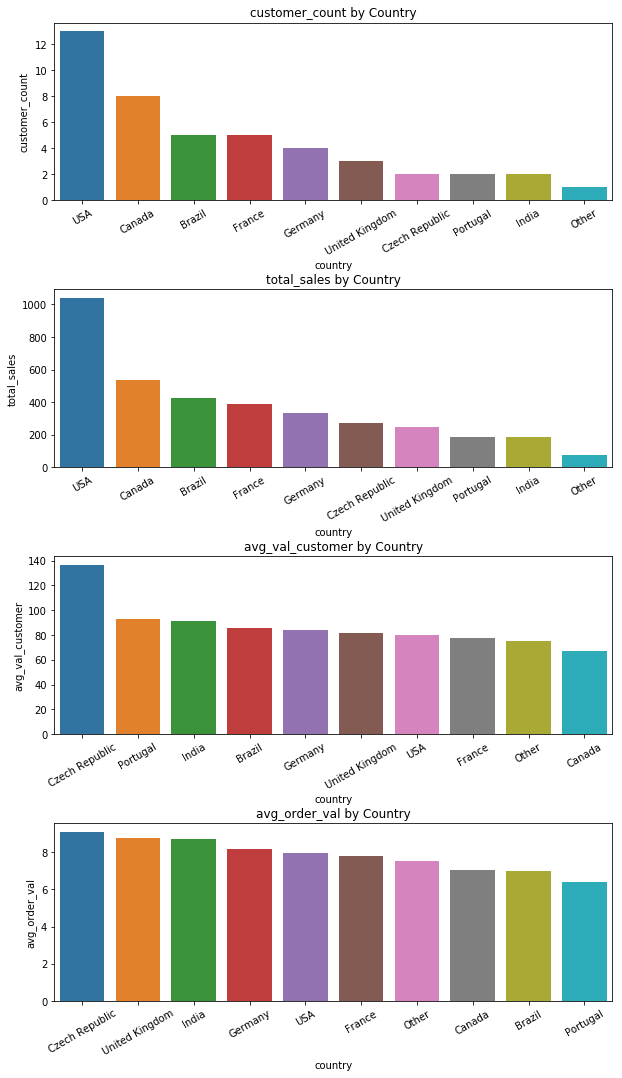

In [66]:
fg, ax =  plt.subplots(4, 1, figsize=(10,18))
# add horizontal space between axes
fg.subplots_adjust(hspace=.5)

cols = ['customer_count','total_sales', 'avg_val_customer', 'avg_order_val']
i = 0
for each in cols:
    srted = countryAggs.sort_values(by = [each], ascending=False)
    sns.barplot(x="country", y= each, data=srted, ax=ax[i])
    ax[i].set_title(each + ' by Country')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)
    i += 1

plt.show()

To grow, you would want more customer in countries where customers are valuable. For that the third chart is most indicative. The Czech Republic has the most value per customer. It would be good to have more such customers. Though a note of caution here. There are only two customers in the Czech Republic so far, and it's possible new customers might not be as valuable as the existing. Similar story for Portugal and India the next two on the customer value list.

### Identifying Album Purchases

The Chinook store allows customers to either purchase a whole album, or to purchase one or more individual tracks.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

You have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to make their decision.

In [95]:
# What does the invoice table look like?
q = '''

SELECT * 
FROM invoice
LIMIT 10;
'''

run_query(q)


,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83
5,6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98
6,7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89
7,8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.90
8,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91
9,10,31,2017-01-18 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98


In [71]:
#How many invoices are there? 
q = '''

SELECT COUNT(DISTINCT invoice_id) 
FROM invoice

'''

run_query(q)

,COUNT(DISTINCT invoice_id)
0,614


In [70]:
# How can I figure out which tracks are on a particular invoice? 

q4 = '''

SELECT * 
FROM invoice_line
WHERE invoice_id = 1
'''

run_query(q4)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1
5,6,1,1163,0.99,1
6,7,1,1164,0.99,1
7,8,1,1165,0.99,1
8,9,1,1166,0.99,1
9,10,1,1167,0.99,1


In [79]:
# How do you figure out which album these tracks are on? 

q = '''

SELECT il.*, al.title album, al.album_id
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN album al ON al.album_id = t.album_id
WHERE il.invoice_id = 1;

'''
run_query(q)

,invoice_line_id,invoice_id,track_id,unit_price,quantity,album,album_id
0,1,1,1158,0.99,1,Use Your Illusion I,91
1,2,1,1159,0.99,1,Use Your Illusion I,91
2,3,1,1160,0.99,1,Use Your Illusion I,91
3,4,1,1161,0.99,1,Use Your Illusion I,91
4,5,1,1162,0.99,1,Use Your Illusion I,91
5,6,1,1163,0.99,1,Use Your Illusion I,91
6,7,1,1164,0.99,1,Use Your Illusion I,91
7,8,1,1165,0.99,1,Use Your Illusion I,91
8,9,1,1166,0.99,1,Use Your Illusion I,91
9,10,1,1167,0.99,1,Use Your Illusion I,91


In [80]:
# How do I find out which tracks are on a particular album? 

q = '''

SELECT t.name, al.title
FROM track t 
INNER JOIN album al ON al.album_id = t.album_id
WHERE al.album_id = 91
'''
run_query(q)

,name,title
0,Right Next Door to Hell,Use Your Illusion I
1,Dust N' Bones,Use Your Illusion I
2,Live and Let Die,Use Your Illusion I
3,Don't Cry (Original),Use Your Illusion I
4,Perfect Crime,Use Your Illusion I
5,You Ain't the First,Use Your Illusion I
6,Bad Obsession,Use Your Illusion I
7,Back off Bitch,Use Your Illusion I
8,Double Talkin' Jive,Use Your Illusion I
9,November Rain,Use Your Illusion I


In [94]:
# ok let's try the except bit and see if we can figure out whether two things are the same or not


q = '''
WITH 
    tracks_album AS
    (
        SELECT t.track_id, al.album_id
        FROM track t 
        INNER JOIN album al ON al.album_id = t.album_id
        WHERE al.album_id = 91
    ), 
    invoice_tracks AS
    (
        SELECT t.track_id, al.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        WHERE il.invoice_id = 1
    ),
    compare_invoice_album AS
    (
        SELECT * FROM tracks_album
        EXCEPT
        SELECT * FROM invoice_tracks
    )

SELECT
    CASE 
        WHEN (SELECT track_id FROM compare_invoice_album) IS NULL THEN 1
        ELSE 0
        END AS album_purchase

'''
run_query(q)


,album_purchase
0,1


In [106]:
# Let's try a simpler example. On any given invoice, how many unique albums are purchased? 

q = '''
WITH 
    unique_album AS 
    (
        SELECT il.invoice_id, COUNT(DISTINCT al.album_id) albums
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        GROUP BY il.invoice_id
  
    )

SELECT 
    i.invoice_id,
    (SELECT albums FROM unique_album ua WHERE ua.invoice_id = i.invoice_id) distinct_albums
FROM invoice i
ORDER BY 1
LIMIT 10;

'''

run_query(q)


,invoice_id,distinct_albums
0,1,1
1,2,10
2,3,2
3,4,8
4,5,1
5,6,2
6,7,11
7,8,10
8,9,9
9,10,2


So here's how I think this should be done: 
- 1 start with a table that has invoice id and albums in that invoice
- 2 add a column to that is 1 if whole album is purchased, and 2 if whole album is not purchased
    - A. uses album info and invoice id to look at which tracks were bought from that album on that particular invoice
    - B. uses album info to pull a total list of all the tracks on that album
    - compares the two above and returns 2B EXCEPT 2A which will tell you if there are tracks on an album that were not bought. So if this is NOT NULL then whole album was not purchased. If it is NULL whole album purchased is 1.  
- 3 consolidate and product the aggregate statistics

In [141]:
q = '''
WITH 
    invoice_album AS 
    (
        SELECT DISTINCT il.invoice_id, al.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        ORDER BY il.invoice_id
    ),
    invoice_track AS
    (
        SELECT DISTINCT il.invoice_id, al.album_id, t.track_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        ORDER BY il.invoice_id

    ), 
    album_track AS
    (
        SELECT al.album_id, t.track_id
        FROM album al
        INNER JOIN track t ON t.album_id = al.album_id
    ), 
    album_purchases AS
    (
        SELECT
            ia.invoice_id,
            ia.album_id,
            CASE
                WHEN
                    (SELECT
                        at.track_id
                    FROM album_track at
                    WHERE at.album_id = ia.album_id

                    EXCEPT

                    SELECT 
                        it.track_id
                    FROM invoice_track it 
                    WHERE it.invoice_id=ia.invoice_id AND it.album_id=ia.album_id
                    ) IS NOT NULL THEN 0

                    ELSE 1

            END AS full_album_purchase
        FROM invoice_album ia
    ),
    album_purchases_consolidated AS
    (

        SELECT 
            invoice_id,
            CASE
                WHEN SUM(full_album_purchase) > 0 THEN 1
                ELSE 0
            END AS album_purchase 
        FROM album_purchases
        GROUP BY invoice_id
    )
    

SELECT
    COUNT(invoice_id) total_invoices,
    SUM(album_purchase) total_album_purchases,
    100*(CAST(SUM(album_purchase) AS FLOAT) / CAST(COUNT(invoice_id) AS FLOAT)) pct_album_purchases
FROM album_purchases_consolidated
'''

run_query(q)

,total_invoices,total_album_purchases,pct_album_purchases
0,614,201,32.736156


### Identifying Album Purchases - Part 2
There is an extra layer of complexity that wasn't accounted for in the previous scenario - the Chinook store prevents customers from buying the same track twice, so an album purchase won't include every track from the album if the customer already owns one or more tracks. Note: invoice_id's are assigned sequentially so you can use that to identify all invoices issued before the current invoice.

I think this can be done with a minor tweak to the invoice track query above. I need to have customer id there. And since invoice ids are sequenctial, I can look for invoices ids less than the current one. 

In [143]:
q = '''
SELECT DISTINCT i.customer_id, il.invoice_id, al.album_id, t.track_id
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
ORDER BY il.invoice_id
LIMIT 10;
'''

run_query(q)

,customer_id,invoice_id,album_id,track_id
0,18,1,91,1158
1,18,1,91,1159
2,18,1,91,1160
3,18,1,91,1161
4,18,1,91,1162
5,18,1,91,1163
6,18,1,91,1164
7,18,1,91,1165
8,18,1,91,1166
9,18,1,91,1167


In [144]:
q = '''
WITH 
    invoice_album AS 
    (
        SELECT DISTINCT i.customer_id, il.invoice_id, al.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        ORDER BY il.invoice_id
    ),
    invoice_track AS
    (
        SELECT DISTINCT i.customer_id, il.invoice_id, al.album_id, t.track_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        INNER JOIN album al ON al.album_id = t.album_id
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        ORDER BY il.invoice_id
    ), 
    album_track AS
    (
        SELECT al.album_id, t.track_id
        FROM album al
        INNER JOIN track t ON t.album_id = al.album_id
    ), 
    album_purchases AS
    (
        SELECT
            ia.invoice_id,
            ia.album_id,
            CASE
                WHEN
                    (SELECT
                        at.track_id
                    FROM album_track at
                    WHERE at.album_id = ia.album_id

                    EXCEPT

                    SELECT 
                        it.track_id
                    FROM invoice_track it 
                    WHERE it.invoice_id<=ia.invoice_id AND it.album_id=ia.album_id AND it.customer_id = ia.customer_id
                    ) IS NOT NULL THEN 0

                    ELSE 1

            END AS full_album_purchase
        FROM invoice_album ia
    ),
    album_purchases_consolidated AS
    (

        SELECT 
            invoice_id,
            CASE
                WHEN SUM(full_album_purchase) > 0 THEN 1
                ELSE 0
            END AS album_purchase 
        FROM album_purchases
        GROUP BY invoice_id
    )
    

SELECT
    COUNT(invoice_id) total_invoices,
    SUM(album_purchase) total_album_purchases,
    100*(CAST(SUM(album_purchase) AS FLOAT) / CAST(COUNT(invoice_id) AS FLOAT)) pct_album_purchases
FROM album_purchases_consolidated
'''

run_query(q)

,total_invoices,total_album_purchases,pct_album_purchases
0,614,223,36.319218


About 36% of albums are are bought all at once. Which is to say most of the time customers buy tracks. As such Chinook, could move to a tracks only model. 